# AI Search with RAG optimization
This document illustrates an example workflow for how to optimize Azure AI Search for RAG use cases to enhance the quality of document search. 

# Objective
See if your RAG app's quality metrics improve using only the capabilities of Azure AI Search
- Enhanced Vector (text-embedding3-large)
- Multivector
- BM25 + Vector
- BM25 + Vector + Semantic Reranking
- BM25 + Vector + Semantic Reranking + Query Rewrite


## Prerequisites
Configure a Python virtual environment for 3.10 or later: 
 1. open the Command Palette (Ctrl+Shift+P).
 1. Search for Python: Create Environment.
 1. select Venv / Conda and choose where to create the new environment.
 1. Select the Python interpreter version. Create with version 3.10 or later.

For a dependency installation, run the code below to install the packages required to run it. 

```bash
pip install -r requirements.txt
```

## Set up your environment
Git clone the repository to your local machine. 

```bash
git clone https://github.com/hyogrin/Azure_OpenAI_samples.git
```

Create an .env file based on the .env-sample file. Copy the new .env file to the folder containing your notebook and update the variables.

In [ ]:
import os
from azure.search.documents import SearchItemPaged
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizedQuery,
    SearchScoreThreshold,
    VectorSimilarityThreshold,
    QueryType, 
    QueryAnswerType,
    QueryCaptionType,
    QueryDebugMode,
    
)
from azure.search.documents import SearchClient
from dotenv import load_dotenv

load_dotenv(override=True)   


search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_api_version = os.getenv("AZURE_OPENAI_CHAT_API_VERSION")
ada002_deployment = os.getenv("AZURE_OPENAI_ADA002_EMBEDDING_DEPLOYMENT_NAME")
large3_deployment = os.getenv("AZURE_OPENAI_3_LARGE_EMBEDDING_DEPLOYMENT_NAME")
gpt_chat_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
ai_project_conn_str = os.getenv("AZURE_AI_PROJECT_CONN_STR")

QUERIES_FILE = "data/rag_sample_qna_ko.jsonl"

print(f"search_endpoint: {search_endpoint}")

In [19]:

def print_results(results: SearchItemPaged[dict]):
    semantic_answers = results.get_answers()
    if semantic_answers:
        for answer in semantic_answers:
            if answer.highlights:
                print(f"Semantic Answer: {answer.highlights}")
            else:
                print(f"Semantic Answer: {answer.text}")
            print(f"Semantic Answer Score: {answer.score}\n")

    for result in results:
        # print(f"Title: {result['title']}")  
        print(f"Score: {result['@search.score']}")
        if result.get('@search.reranker_score'):
            print(f"Reranker Score: {result['@search.reranker_score']}")
        print(f"Content: {result['content']}")  
        # print(f"Category: {result['new_product_name']}\n")

        captions = result["@search.captions"]
        if captions:
            caption = captions[0]
            if caption.highlights:
                print(f"Caption: {caption.highlights}\n")
            else:
                print(f"Caption: {caption.text}\n")
        print("-" * 200)

In [20]:
embed_client = AzureOpenAI(
    azure_deployment=ada002_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_api_key,
)

embed3_client = AzureOpenAI(
    azure_deployment=large3_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_api_key,
)

search_client = SearchClient(endpoint=search_endpoint, index_name=index_name, credential=AzureKeyCredential(admin_key))

with open('main_prompt_plain.txt', 'r') as file:
    prompt_template = file.read()

## SEMANTIC, HYBRID, RERANKER, REWRITE Search 

In [21]:
from enum import Enum

class SearchType(Enum):   
    SEMANTIC = "semantic"
    HYBRID = "hybrid"
    SEMANTIC_WITH_RERANKER = "semantic_with_reranker"
    HYBRID_WITH_RERANKER = "hybrid_with_reranker"
    SEMANTIC_WITH_RERANKER_REWRITE = "semantic_with_reranker_rewrite"
    HYBRID_WITH_RERANKER_REWRITE = "hybrid_with_reranker_rewrite"
    

def search_with_type(search_type, embedding, category, type, query_text=None, vector_field="content_vector", similarity_threshold=None):
    results = None
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=50, fields=vector_field, threshold=similarity_threshold
                                )
    if search_type == SearchType.SEMANTIC:
        results = search_client.search(
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            top=3
        )
    elif search_type == SearchType.HYBRID:
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            top=3
        )
    elif search_type == SearchType.HYBRID_WITH_RERANKER:        
        results = search_client.search(
            search_text=query_text,
            # search_text=None, # use No-BM25 search
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            # https://learn.microsoft.com/en-us/azure/search/semantic-how-to-query-rewrite
            query_language="ko-KR",
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,    
            top=3
        )
    elif search_type == SearchType.HYBRID_WITH_RERANKER_REWRITE:
        results = search_client.search(
            # search_text=query_text,
            # Semantic search query rewrite is not available for this service.
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            # https://learn.microsoft.com/en-us/azure/search/semantic-how-to-query-rewrite
            query_language="ko-KR",
            query_rewrites="generative|count-5",
            debug=QueryDebugMode.QUERY_REWRITES,
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,    
            top=3
            
    )
    return results
    return results

In [22]:
import json

def save_search_result(search_type, embedding_model, search_result_file_name, line_num, similarity_threshold=None):
    def get_embedding(query):
        return embed_client.embeddings.create(input=[query], model=embedding_model).data[0].embedding

    query_document = []

    with open(QUERIES_FILE, 'r') as f:
        for i, line in enumerate(f):
            # initialize the list to store documents for each query
            documents = []
            if i >= line_num:  # Limit to processing questions
                break
            query = json.loads(line.strip())  # Parse each line as a JSON object
            embedding = get_embedding(query['question'])
            category = query['category']
            type = query['type']
            results = search_with_type(search_type, embedding, category, type, query['question'], vector_field="content_vector", similarity_threshold=similarity_threshold) 
            #print_results(results)
            
            for res in results:
                documents.append(res['content'])
            
            if len(documents) > 0:
                document_content = "\n".join(documents)
            else:
                document_content = "No documents found."
            query_document.append({"query": query['question'], "document_content": document_content})
    
    with open(f'{search_result_file_name}', 'w') as outfile:
        json.dump(query_document, outfile, ensure_ascii=False, indent=4)

## Save the search results for each search method

In [23]:
NUMBER_OF_QUESTIONS = 10
#similarity_threshold = VectorSimilarityThreshold(value=0.78)
similarity_threshold = None

In [24]:
# [ada002] SEMANTIC Search
print("=== [ada002] SEMANTIC Search ===")
save_search_result(SearchType.SEMANTIC, ada002_deployment, 'result_search/queries_contexts_ada2_semantic.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [ada002] HYBRID Search
print("=== [ada002] HYBRID Search ===")
save_search_result(SearchType.HYBRID, ada002_deployment, 'result_search/queries_contexts_ada2_hybrid.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
save_search_result(SearchType.HYBRID, large3_deployment, 'result_search/queries_contexts_large3_hybrid.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
save_search_result(SearchType.HYBRID_WITH_RERANKER, large3_deployment, 'result_search/queries_contexts_large3_hybrid_reranker.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
save_search_result(SearchType.HYBRID_WITH_RERANKER_REWRITE, large3_deployment, 'result_search/queries_contexts_large3_hybrid_reranker_rewrite.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

=== [ada002] SEMANTIC Search ===


=== [ada002] HYBRID Search ===
=== [large3] HYBRID Search ===
=== [large3] HYBRID + RERANKER Search ===
=== [large3] HYBRID + RERANKER + REWRITE Search ===


## Get answer with RAG orchestrator

In [25]:
def save_response_use_llm(search_result_file_name, response_file_name):
    def process_llm(query, document_content):
        openai_client = AzureOpenAI(
        azure_deployment=gpt_chat_deployment,
        api_version=openai_api_version,
        azure_endpoint=openai_endpoint,
        api_key=openai_api_key,
    )

        prompt = prompt_template.replace("{question}", query)
        prompt = prompt.replace("{document}", document_content)
        response = openai_client.chat.completions.create(
        model=gpt_chat_deployment,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

        answer = response.choices[0].message.content.strip()
        return answer

    with open(f'{search_result_file_name}', 'r') as f:
        queries_document = json.load(f)

    query_answers_contexts = []

    for query_doc in queries_document:
        query = query_doc['query']
        document_content = query_doc['document_content']
        answer = process_llm(query, document_content) 
    # print(f"Query: {query}\nAnswer: {answer}\n")

        query_answers_contexts.append({
        "query": query,
        "document_content": document_content,
        "answer": answer
    })

    with open(f'{response_file_name}', 'w') as outfile:
        for item in query_answers_contexts:
            json.dump(item, outfile, ensure_ascii=False)
            outfile.write('\n')


In [26]:
# [ada002] SEMANTIC Search
print("=== [ada002] SEMANTIC Search ===")
save_response_use_llm('result_search/queries_contexts_ada2_semantic.json', 'result_response/queries_responses_ada2_semantic.jsonl')

# [ada002] HYBRID Search
print("=== [ada002] HYBRID Search ===")
save_response_use_llm('result_search/queries_contexts_ada2_hybrid.json', 'result_response/queries_responses_ada2_hybrid.jsonl')

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid.json', 'result_response/queries_responses_large3_hybrid.jsonl')

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid_reranker.json', 'result_response/queries_responses_large3_hybrid_reranker.jsonl')

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid_reranker_rewrite.json', 'result_response/queries_responses_hybrid_reranker_rewrite.jsonl')

=== [ada002] SEMANTIC Search ===
=== [ada002] HYBRID Search ===
=== [large3] HYBRID Search ===
=== [large3] HYBRID + RERANKER Search ===
=== [large3] HYBRID + RERANKER + REWRITE Search ===


## Evaluate by Azure AI Evaluator

In [27]:
import os
from datetime import datetime
from azure.ai.evaluation import (
    evaluate, 
    FluencyEvaluator, 
    GroundednessEvaluator, 
    RelevanceEvaluator, 
    CoherenceEvaluator,
    SimilarityEvaluator,
    RetrievalEvaluator

)

column_mapping = {
    "query": "${data.query}",
    "context": "${data.document_content}",
    "response": "${data.answer}"
}


model_config = {
    "azure_endpoint": openai_endpoint,
    "api_key": openai_api_key,
    "azure_deployment": gpt_chat_deployment,
    "api_version": openai_api_version,
}


retrievalEvaluator = RetrievalEvaluator(model_config)
fluencyEvaluator = FluencyEvaluator(model_config)
groundednessEvaluator = GroundednessEvaluator(model_config)
relevanceEvaluator = RelevanceEvaluator(model_config)
coherenceEvaluator = CoherenceEvaluator(model_config)
similarityEvaluator = SimilarityEvaluator(model_config)

azure_ai_project_conn_str = os.environ.get("AZURE_AI_PROJECT_CONN_STR")
subscription_id = azure_ai_project_conn_str.split(";")[1]
resource_group_name = azure_ai_project_conn_str.split(";")[2]
project_name = azure_ai_project_conn_str.split(";")[3]

azure_ai_project = {
    "subscription_id": subscription_id,
    "resource_group_name": resource_group_name,
    "project_name": project_name,
}

In [ ]:
def azure_evaluator(eval_name, response_file_name, eval_output_file_name):
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M")
    
    result = evaluate(
    evaluation_name=f"rag_opt_{eval_name}_{current_time}",
    data=f"{response_file_name}",
    evaluators={
        # "fluency": fluencyEvaluator,
        # "groundedness": groundednessEvaluator,
        "retrieval": retrievalEvaluator,
        "relevance": relevanceEvaluator,
        # "coherence": coherenceEvaluator,
        # "similarity": similarityEvaluator,
    },
    evaluator_config={
        "retrieval": {"column_mapping": column_mapping},
        # "fluency": {
        #     "column_mapping": column_mapping
        # },
        # "groundedness": {
        #     "column_mapping": column_mapping
        # },
        "relevance": {
            "column_mapping": column_mapping
        },
        # "coherence": {
        #     "column_mapping": column_mapping
        # },
        # "similarity": {
        #     "column_mapping": column_mapping
        # }
    },
    #azure_ai_project=azure_ai_project,
    # for upload the result into the Azure AI project, please uncomment the above line
    # if you run into an issue of the permission, check the link https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/evaluation/azure-ai-evaluation/TROUBLESHOOTING.md
    output_path=eval_output_file_name
    )
    return result


In [ ]:
# [ada002] SEMANTIC Search
print("=== [ada002] SEMANTIC Search ===")
azure_evaluator('ada2_semantic', 'result_response/queries_responses_ada2_semantic.jsonl', 'result_eval/eval_ada2_semantic.json')

# [ada002] HYBRID Search
print("=== [ada002] HYBRID Search ===")
azure_evaluator('ada2_hybrid', 'result_response/queries_responses_ada2_hybrid.jsonl', 'result_eval/eval_ada2_hybrid.json')

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
azure_evaluator('large3_hybrid', 'result_response/queries_responses_large3_hybrid.jsonl', 'result_eval/eval_large3_hybrid.json')

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
azure_evaluator('large3_hybrid_reranker', 'result_response/queries_responses_large3_hybrid_reranker.jsonl', 'result_eval/eval_large3_hybrid_reranker.json')

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
azure_evaluator('large3_hybrid_reranker_rewrite', 'result_response/queries_responses_large3_hybrid_reranker_rewrite.jsonl', 'result_eval/eval_hybrid_reranker_rewrite.json')

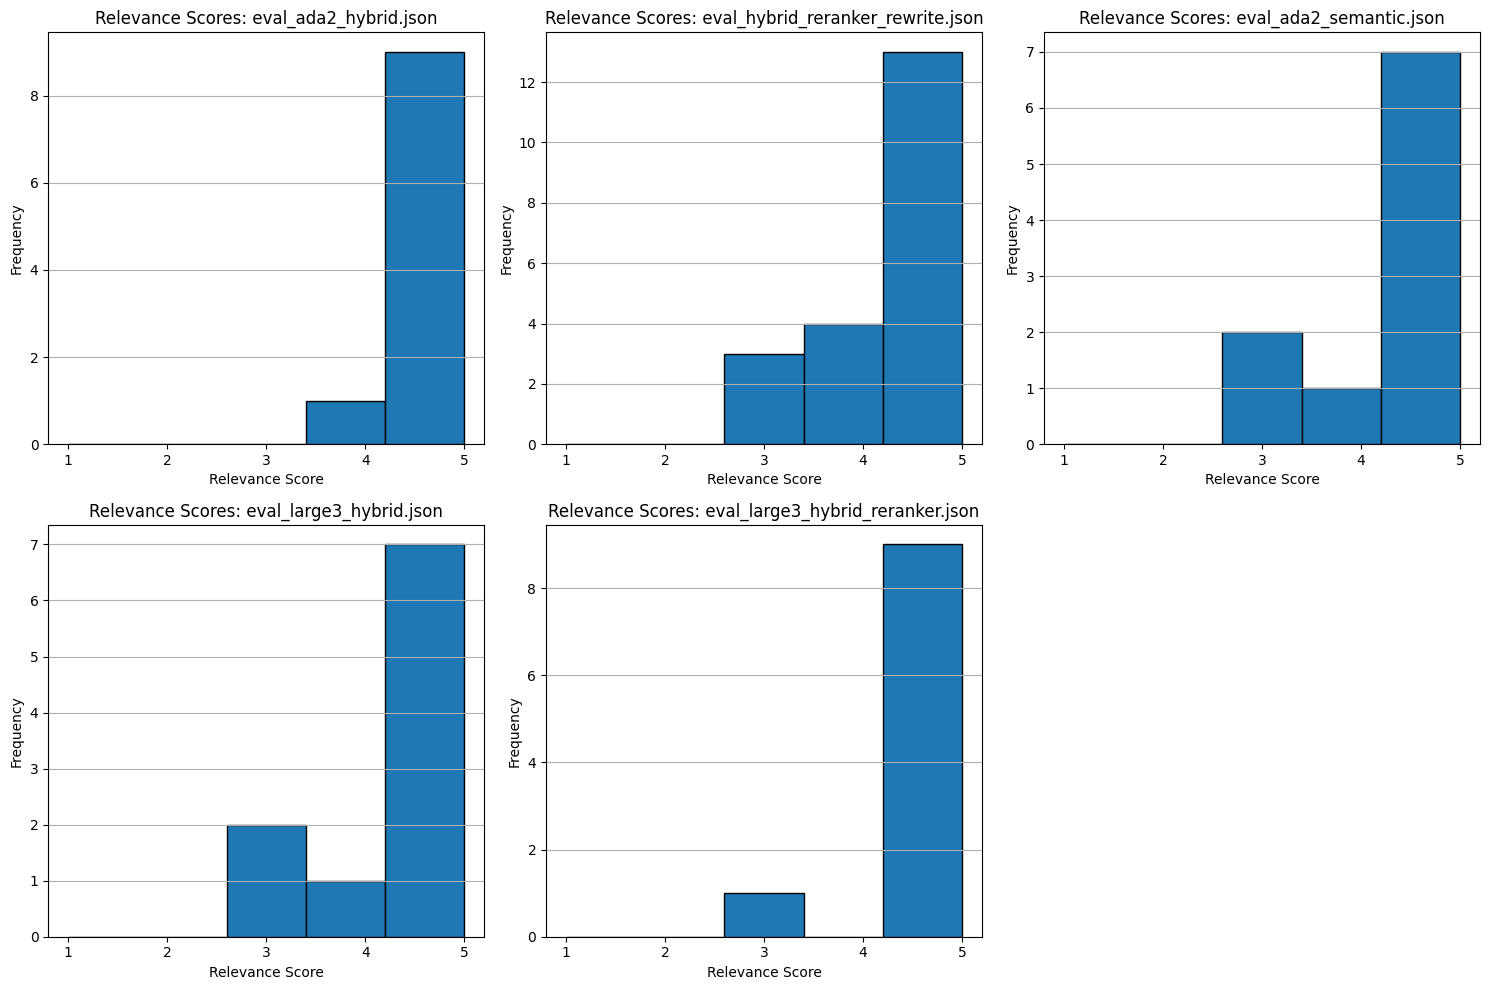

In [30]:
import json
import os
import matplotlib.pyplot as plt

# Directory containing evaluation result JSON files
eval_dir = 'result_eval'

# Get all JSON files in the directory
eval_files = [f for f in os.listdir(eval_dir) if f.endswith('.json')]

# Initialize a figure for the plots
num_files = len(eval_files)
rows = (num_files + 2) // 3  # Calculate the number of rows (3 graphs per row)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Loop through each file and plot the relevance scores
for i, eval_file in enumerate(eval_files):
    with open(os.path.join(eval_dir, eval_file), 'r') as f:
        evaluation_results = json.load(f)

    # Extract the relevance scores
    relevance_scores = [row['outputs.relevance.relevance'] for row in evaluation_results['rows']]

    # Plot the relevance scores
    axes[i].hist(relevance_scores, bins=5, range=(1, 5), edgecolor='black')
    axes[i].set_title(f'Relevance Scores: {eval_file}')
    axes[i].set_xlabel('Relevance Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(1, 6))
    axes[i].grid(axis='y')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

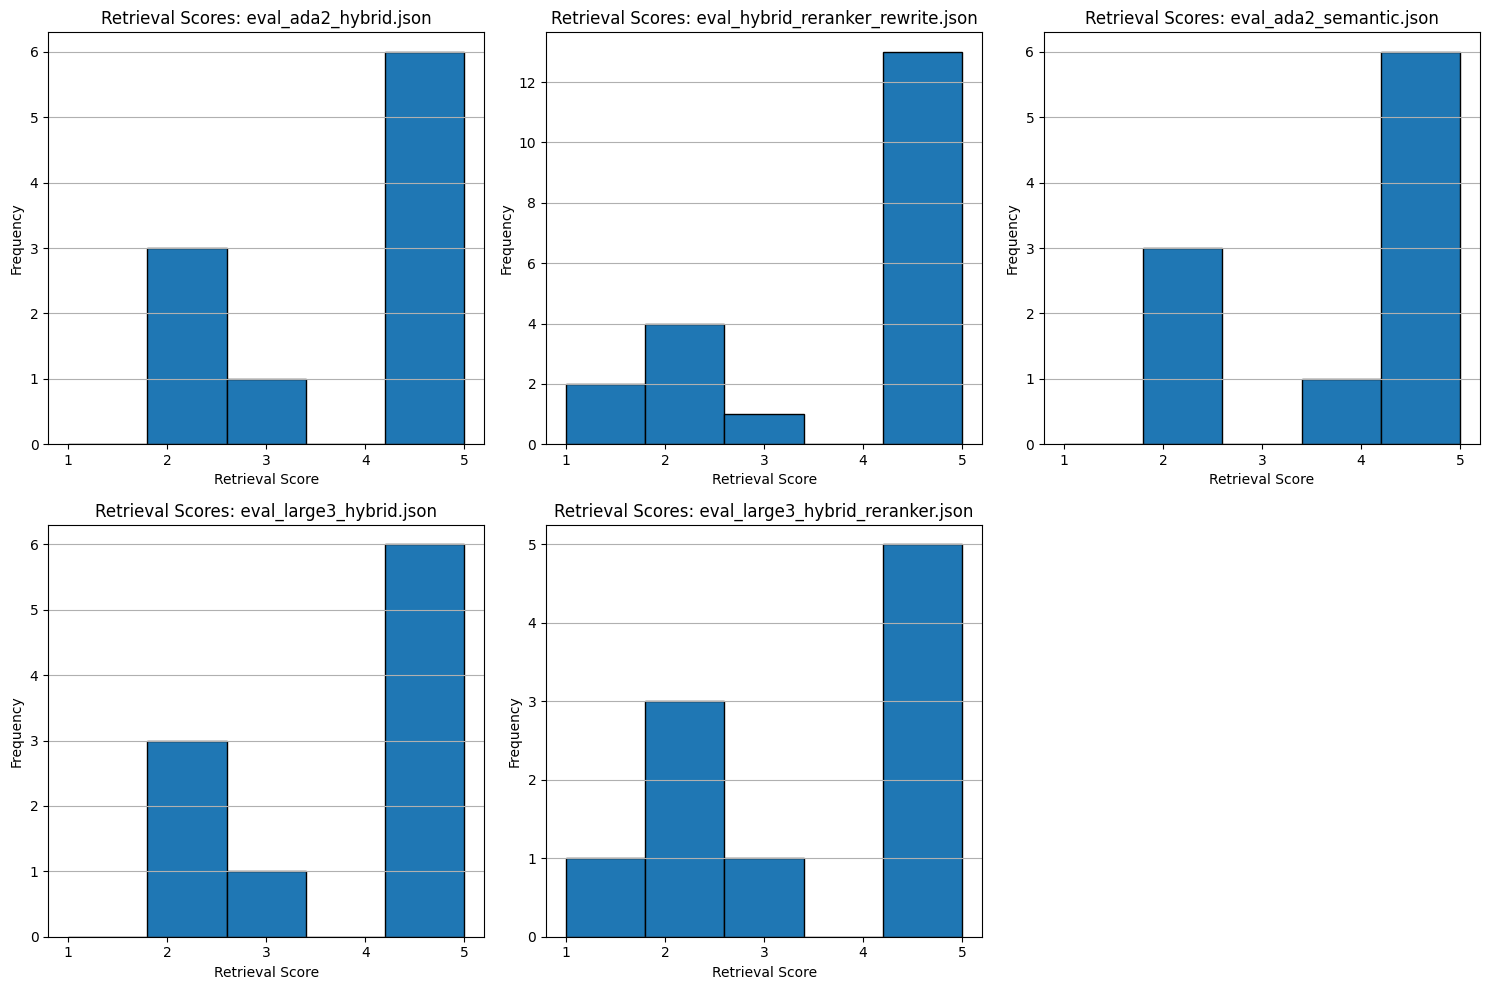

In [31]:
import json
import os
import matplotlib.pyplot as plt

# Directory containing evaluation result JSON files
eval_dir = 'result_eval'

# Get all JSON files in the directory
eval_files = [f for f in os.listdir(eval_dir) if f.endswith('.json')]

# Initialize a figure for the plots
num_files = len(eval_files)
rows = (num_files + 2) // 3  # Calculate the number of rows (3 graphs per row)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Loop through each file and plot the relevance scores
for i, eval_file in enumerate(eval_files):
    with open(os.path.join(eval_dir, eval_file), 'r') as f:
        evaluation_results = json.load(f)

    # Extract the relevance scores
    relevance_scores = [row['outputs.retrieval.retrieval'] for row in evaluation_results['rows']]

    # Plot the relevance scores
    axes[i].hist(relevance_scores, bins=5, range=(1, 5), edgecolor='black')
    axes[i].set_title(f'Retrieval Scores: {eval_file}')
    axes[i].set_xlabel('Retrieval Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(1, 6))
    axes[i].grid(axis='y')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Check Relevance Scores of 3 or less

In [34]:
low_relevance_queries = [(index, row['inputs.query']) for index, row in enumerate(evaluation_results['rows']) if row['outputs.relevance.relevance'] <= 3]


In [35]:
low_relevance_queries

[(6, 'UX 개선 사항은 무엇인가요?')]